In [76]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

In [82]:
def region_selection_road(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have 
		identified edges in the frame
	"""
	# create an array of the same size as of the input image 
	mask = np.zeros_like(image) 
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
 
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.02, rows * 0.65]
	top_left	 = [cols * 0.02, rows * 0.95]
	bottom_right = [cols * 0.99, rows * 0.65]
	top_right = [cols * 0.99, rows * 0.95]
 
 
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image

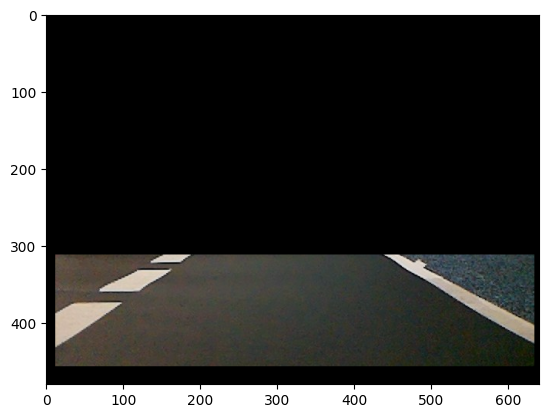

In [78]:
image = cv2.imread('test_face_sign.jpg')

masked_image = region_selection_road(image)

plt.imshow(masked_image)

In [79]:
def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)
	
	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	# 
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full length lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line

	
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness. 
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

In [80]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
    Parameters:
        image: image of a road where one wants to detect lane lines
        (we will be passing frames of video to this function)
    """
    # Convert the RGB image to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to remove noise from the frames
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)
    
    # Thresholding to ignore dark colors
    _, thresholded = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)

    # Canny edge detection
    edges = cv2.Canny(thresholded, 100, 200) 
    
    # Region selection mask
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1] / 2, imshape[0] / 2), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Hough transform to detect lines
    lines = cv2.HoughLinesP(masked_edges, 2, np.pi/180, 15, np.array([]), minLineLength=10, maxLineGap=20)
    
    # Draw the detected lines on the original image
    result = np.copy(image)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    return result



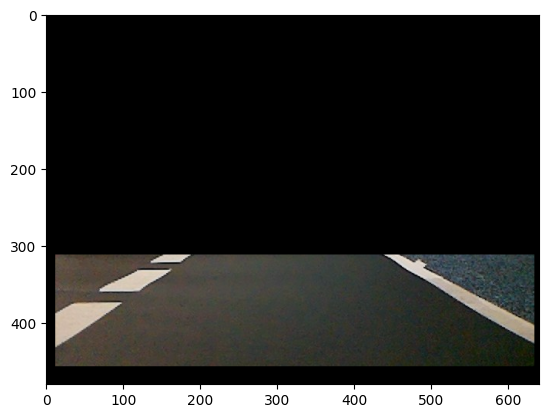

In [81]:
# Creates the environment of 
# the picture and shows it
image = cv2.imread('test_face_sign.jpg')

lines = frame_processor(image)

masked_image = region_selection_road(image)

frame = frame_processor(masked_image)

plt.subplot(1, 1, 1)
plt.imshow(frame)
plt.show()
